<a href="https://colab.research.google.com/github/analyticsindiamagazine/Notebooks/blob/master/Obstacle_Tower_PPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from obstacle_tower_env import ObstacleTowerEnv
%matplotlib inline
from matplotlib import pyplot as plt

In [0]:
env = ObstacleTowerEnv('./ObstacleTower/obstacletower', retro=False, realtime_mode=False)

INFO:mlagents.envs:
'ObstacleTower-v3.1' started successfully!
Unity Academy name: ObstacleTower-v3.1
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		starting-floor -> 0.0
		visual-theme -> 1.0
		allowed-rooms -> 2.0
		dense-reward -> 1.0
		total-floors -> 100.0
		agent-perspective -> 1.0
		tower-seed -> -1.0
		default-theme -> 0.0
		allowed-floors -> 2.0
		allowed-modules -> 2.0
		lighting-type -> 1.0
Unity brain name: LearningBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3, 3, 2, 3]
        Vector Action descriptions: Movement Forward/Back, Camera, Jump, Movement Left/Right
INFO:gym_unity:1 agents within environment.
/Users/anurag/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered b

In [0]:
env.action_space

MultiDiscrete([3 3 2 3])

In [0]:
env.observation_space

Tuple(Box(168, 168, 3), Discrete(5), Box(1,), Discrete(9999))

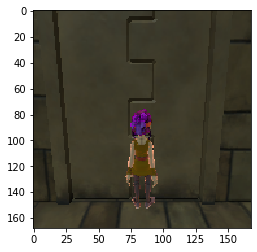

In [0]:
obs = env.reset()
fig = plt.figure();
plt.imshow(obs[0]);

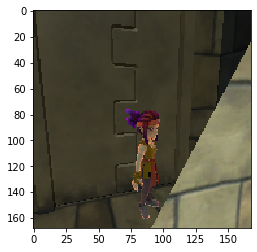

In [0]:
obs, reward, done, info = env.step(env.action_space.sample())
plt.imshow(obs[0]);

In [0]:
# Seeds can be chosen from range of 0-100.
env.seed(5)

In [0]:
# Floors can be chosen from range of 0-100.
env.floor(15)

In [0]:
# Additional reset parameters can be set using a config dictionary
# Here we set the agent perspective to first-person mode.
config = {'agent-perspective': 0}

INFO:mlagents.envs:Academy reset with parameters: agent-perspective -> 0, starting-floor -> 15, tower-seed -> 5


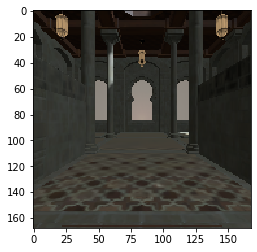

In [0]:
# These parameters won't take place until the next reset.
obs = env.reset(config=config)
plt.imshow(obs[0]);

In [0]:
#close the previous environment.
env.close()

## PPO Training - Obstacle Tower

In [0]:
import imageio
import time
import numpy as np
import gym
from stable_baselines.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines.ddpg.policies import CnnPolicy
from stable_baselines.common.policies import MlpLstmPolicy, CnnLstmPolicy
from stable_baselines import A2C, PPO2

from stable_baselines.bench import Monitor
from stable_baselines.results_plotter import load_results, ts2xy

/Users/anurag/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/anurag/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/anurag/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/anurag/opt/anaconda3/lib/python3.7/site-packages/tensorflow/

INFO:mlagents.envs:
'ObstacleTower-v3.1' started successfully!
Unity Academy name: ObstacleTower-v3.1
        Number of Brains: 1
        Number of Training Brains : 1
        Reset Parameters :
		allowed-floors -> 2.0
		allowed-modules -> 2.0
		lighting-type -> 1.0
		starting-floor -> 0.0
		visual-theme -> 1.0
		allowed-rooms -> 2.0
		dense-reward -> 1.0
		total-floors -> 100.0
		agent-perspective -> 1.0
		tower-seed -> -1.0
		default-theme -> 0.0
Unity brain name: LearningBrain
        Number of Visual Observations (per agent): 1
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): [3, 3, 2, 3]
        Vector Action descriptions: Movement Forward/Back, Camera, Jump, Movement Left/Right
INFO:gym_unity:1 agents within environment.


Box(84, 84, 3)
(84, 84, 3)


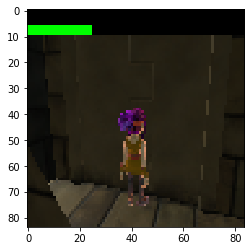

In [0]:
env = ObstacleTowerEnv('./ObstacleTower/obstacletower', retro=True)

# In retro mode, the observation is an 84x84 image with the time remaining and key count visually embedded.
print(env.observation_space)


obs = env.reset()
print(obs.shape)

obs, reward, done, info = env.step(env.action_space.sample())
plt.imshow(obs);

In [0]:
best_mean_reward, n_steps = -np.inf, 0

def callback(_locals, _globals):
    """
    Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
    :param _locals: (dict)
    :param _globals: (dict)
    """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        # Evaluate policy training performance
        x, y = ts2xy(load_results(log_dir), 'timesteps')
        if len(x) > 0:
            mean_reward = np.mean(y[-100:])
            print(x[-1], 'timesteps')
            print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

            # New best model, you could save the agent here
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
                # Example for saving best model
                print("Saving new best model")
                _locals['self'].save(log_dir + 'best_model.pkl')
    n_steps += 1
    # Returning False will stop training early
    return True

In [0]:
# Create log dir
import os

log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir, allow_early_resets=True)

In [0]:
#Create a CNN based policy and optimize it using PPO2.
ppo_params = {"gamma" : 0.99,
              "n_steps" : 128,
              "ent_coef" : 0.01,
              "learning_rate" : 0.00025,
              "vf_coef" : 0.5,
              "max_grad_norm" : 0.5,
              "lam" : 0.95,
              "nminibatches" : 4,
              "noptepochs" : 4,
              "cliprange" :0.2,
              "cliprange_vf" : None,
              "verbose" : 1,
              "tensorboard_log" : None,
              "_init_setup_model" : True,
              "policy_kwargs" : None,
              "full_tensorboard_log" : False,
              "seed" : None,
              "n_cpu_tf_sess" : None
              }

timesteps = int(1e5)

def train_save_agent(params=ppo_params, time_steps=timesteps):
    #use the policy, environment and define params to compile the PPO2 model..
    model = PPO2("CnnPolicy", env, **params)

    s_time = time.time()
    #Train the model
    model.learn(total_timesteps=time_steps)
    e_time = time.time()

    print(f"Total Run-Time : , {(e_time - s_time) : 0.3f} seconds")

    ############ Record-GIF ###########
    images = []
    obs = model.env.reset()
    img = model.env.render(mode='rgb_array')
    gif_length = 500

    for i in range(gif_length):
        images.append(img)
        action, _ = model.predict(obs)
        obs, _, _ ,_ = model.env.step(action)
        img = model.env.render(mode='rgb_array')

    imageio.mimsave(f'ppo-obstacle-tower-{timesteps}.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0],
                    fps=10)
    
    return model

In [0]:
##train RL agent..

ot_ppo_agent = train_save_agent(ppo_params)

Wrapping the env in a DummyVecEnv.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


-------------------------------------
| approxkl           | 0.0033812874 |
| clipfrac           | 0.04296875   |
| explained_variance | -3.53        |
| fps                | 52           |
| n_updates          | 1            |
| policy_entropy     | 3.9869604    |
| policy_loss        | -0.03647914  |
| serial_timesteps   | 128          |
| time_elapsed       | 2.86e-06     |
| total_timesteps    | 128          |
| value_loss         | 0.009349779  |
-------------------------------------
-------------------------------------
| approxkl           | 0.02103925   |
| clipfrac           | 0.28320312   |
| explained_variance | -74.1        |
| fps                | 60           |
| n_updates          | 2            |
| policy_entropy     | 3.944655     |
| policy_loss        | -0.038017057 |
| serial_timesteps   | 256          |
| time_elapsed       | 2.43         |
| total_timesteps    | 256          |
| value_loss         | 0.008901308  |
-------------------------------------
------------

-------------------------------------
| approxkl           | 0.015478155  |
| clipfrac           | 0.17773438   |
| ep_len_mean        | 701          |
| ep_reward_mean     | 0.5          |
| explained_variance | -16.3        |
| fps                | 56           |
| n_updates          | 17           |
| policy_entropy     | 3.7044935    |
| policy_loss        | -0.037470907 |
| serial_timesteps   | 2176         |
| time_elapsed       | 39.6         |
| total_timesteps    | 2176         |
| value_loss         | 0.002095155  |
-------------------------------------
-------------------------------------
| approxkl           | 0.01782015   |
| clipfrac           | 0.20898438   |
| ep_len_mean        | 734          |
| ep_reward_mean     | 0.667        |
| explained_variance | -8.06        |
| fps                | 25           |
| n_updates          | 18           |
| policy_entropy     | 3.6436396    |
| policy_loss        | -0.04061823  |
| serial_timesteps   | 2304         |
| time_elaps

-------------------------------------
| approxkl           | 0.040092632  |
| clipfrac           | 0.29882812   |
| ep_len_mean        | 668          |
| ep_reward_mean     | 0.333        |
| explained_variance | -6.9         |
| fps                | 29           |
| n_updates          | 32           |
| policy_entropy     | 3.407418     |
| policy_loss        | -0.046354063 |
| serial_timesteps   | 4096         |
| time_elapsed       | 80.5         |
| total_timesteps    | 4096         |
| value_loss         | 0.0136810765 |
-------------------------------------
-------------------------------------
| approxkl           | 0.048393764  |
| clipfrac           | 0.34960938   |
| ep_len_mean        | 668          |
| ep_reward_mean     | 0.333        |
| explained_variance | -7.88        |
| fps                | 65           |
| n_updates          | 33           |
| policy_entropy     | 3.5146477    |
| policy_loss        | -0.06453506  |
| serial_timesteps   | 4224         |
| time_elaps

-------------------------------------
| approxkl           | 0.016585212  |
| clipfrac           | 0.203125     |
| ep_len_mean        | 676          |
| ep_reward_mean     | 0.4          |
| explained_variance | -4.76        |
| fps                | 64           |
| n_updates          | 47           |
| policy_entropy     | 3.1079051    |
| policy_loss        | -0.041239984 |
| serial_timesteps   | 6016         |
| time_elapsed       | 119          |
| total_timesteps    | 6016         |
| value_loss         | 0.003726306  |
-------------------------------------
-------------------------------------
| approxkl           | 0.018048046  |
| clipfrac           | 0.23046875   |
| ep_len_mean        | 676          |
| ep_reward_mean     | 0.4          |
| explained_variance | -28.8        |
| fps                | 64           |
| n_updates          | 48           |
| policy_entropy     | 3.5975893    |
| policy_loss        | -0.048919715 |
| serial_timesteps   | 6144         |
| time_elaps

-------------------------------------
| approxkl           | 0.023276718  |
| clipfrac           | 0.2421875    |
| ep_len_mean        | 692          |
| ep_reward_mean     | 0.473        |
| explained_variance | -37.5        |
| fps                | 63           |
| n_updates          | 62           |
| policy_entropy     | 3.3651772    |
| policy_loss        | -0.05034419  |
| serial_timesteps   | 7936         |
| time_elapsed       | 160          |
| total_timesteps    | 7936         |
| value_loss         | 0.0018914806 |
-------------------------------------
------------------------------------
| approxkl           | 0.023853559 |
| clipfrac           | 0.30078125  |
| ep_len_mean        | 692         |
| ep_reward_mean     | 0.473       |
| explained_variance | -32.9       |
| fps                | 64          |
| n_updates          | 63          |
| policy_entropy     | 3.3197641   |
| policy_loss        | -0.05819306 |
| serial_timesteps   | 8064        |
| time_elapsed       | 

-------------------------------------
| approxkl           | 0.019030536  |
| clipfrac           | 0.22265625   |
| ep_len_mean        | 701          |
| ep_reward_mean     | 0.536        |
| explained_variance | -40.4        |
| fps                | 27           |
| n_updates          | 77           |
| policy_entropy     | 3.112319     |
| policy_loss        | -0.053074718 |
| serial_timesteps   | 9856         |
| time_elapsed       | 197          |
| total_timesteps    | 9856         |
| value_loss         | 0.002240335  |
-------------------------------------
-------------------------------------
| approxkl           | 0.033487547  |
| clipfrac           | 0.36132812   |
| ep_len_mean        | 701          |
| ep_reward_mean     | 0.536        |
| explained_variance | -11.6        |
| fps                | 65           |
| n_updates          | 78           |
| policy_entropy     | 3.0189583    |
| policy_loss        | -0.06447179  |
| serial_timesteps   | 9984         |
| time_elaps

-------------------------------------
| approxkl           | 0.021211354  |
| clipfrac           | 0.27148438   |
| ep_len_mean        | 714          |
| ep_reward_mean     | 0.594        |
| explained_variance | -26.9        |
| fps                | 62           |
| n_updates          | 92           |
| policy_entropy     | 3.2182786    |
| policy_loss        | -0.061886337 |
| serial_timesteps   | 11776        |
| time_elapsed       | 236          |
| total_timesteps    | 11776        |
| value_loss         | 0.0027250564 |
-------------------------------------
-------------------------------------
| approxkl           | 0.030762995  |
| clipfrac           | 0.33203125   |
| ep_len_mean        | 714          |
| ep_reward_mean     | 0.594        |
| explained_variance | -38          |
| fps                | 63           |
| n_updates          | 93           |
| policy_entropy     | 3.2041664    |
| policy_loss        | -0.054396883 |
| serial_timesteps   | 11904        |
| time_elaps

-------------------------------------
| approxkl           | 0.03199948   |
| clipfrac           | 0.16796875   |
| ep_len_mean        | 706          |
| ep_reward_mean     | 0.558        |
| explained_variance | -9.98        |
| fps                | 66           |
| n_updates          | 107          |
| policy_entropy     | 2.8533463    |
| policy_loss        | -0.052167222 |
| serial_timesteps   | 13696        |
| time_elapsed       | 275          |
| total_timesteps    | 13696        |
| value_loss         | 0.0032050868 |
-------------------------------------
-------------------------------------
| approxkl           | 0.02339238   |
| clipfrac           | 0.2109375    |
| ep_len_mean        | 706          |
| ep_reward_mean     | 0.558        |
| explained_variance | -11          |
| fps                | 62           |
| n_updates          | 108          |
| policy_entropy     | 2.9361482    |
| policy_loss        | -0.05068616  |
| serial_timesteps   | 13824        |
| time_elaps

-------------------------------------
| approxkl           | 0.016808122  |
| clipfrac           | 0.2265625    |
| ep_len_mean        | 701          |
| ep_reward_mean     | 0.527        |
| explained_variance | -10.6        |
| fps                | 64           |
| n_updates          | 122          |
| policy_entropy     | 3.0053608    |
| policy_loss        | -0.06247341  |
| serial_timesteps   | 15616        |
| time_elapsed       | 316          |
| total_timesteps    | 15616        |
| value_loss         | 0.0029447293 |
-------------------------------------
-------------------------------------
| approxkl           | 0.018568164  |
| clipfrac           | 0.26953125   |
| ep_len_mean        | 701          |
| ep_reward_mean     | 0.527        |
| explained_variance | -41.3        |
| fps                | 63           |
| n_updates          | 123          |
| policy_entropy     | 2.9172196    |
| policy_loss        | -0.060304273 |
| serial_timesteps   | 15744        |
| time_elaps

-------------------------------------
| approxkl           | 0.036952652  |
| clipfrac           | 0.3046875    |
| ep_len_mean        | 689          |
| ep_reward_mean     | 0.464        |
| explained_variance | -54.1        |
| fps                | 65           |
| n_updates          | 137          |
| policy_entropy     | 2.1518018    |
| policy_loss        | -0.051652554 |
| serial_timesteps   | 17536        |
| time_elapsed       | 354          |
| total_timesteps    | 17536        |
| value_loss         | 0.007997315  |
-------------------------------------
------------------------------------
| approxkl           | 0.043551315 |
| clipfrac           | 0.31054688  |
| ep_len_mean        | 689         |
| ep_reward_mean     | 0.464       |
| explained_variance | -17.3       |
| fps                | 65          |
| n_updates          | 138         |
| policy_entropy     | 1.986198    |
| policy_loss        | -0.067934   |
| serial_timesteps   | 17664       |
| time_elapsed       | 

-------------------------------------
| approxkl           | 0.022320438  |
| clipfrac           | 0.2578125    |
| ep_len_mean        | 687          |
| ep_reward_mean     | 0.457        |
| explained_variance | -19.4        |
| fps                | 65           |
| n_updates          | 152          |
| policy_entropy     | 2.7226539    |
| policy_loss        | -0.051056124 |
| serial_timesteps   | 19456        |
| time_elapsed       | 392          |
| total_timesteps    | 19456        |
| value_loss         | 0.002429996  |
-------------------------------------
------------------------------------
| approxkl           | 0.033471704 |
| clipfrac           | 0.27734375  |
| ep_len_mean        | 687         |
| ep_reward_mean     | 0.457       |
| explained_variance | -0.0982     |
| fps                | 66          |
| n_updates          | 153         |
| policy_entropy     | 2.7730048   |
| policy_loss        | -0.05484458 |
| serial_timesteps   | 19584       |
| time_elapsed       | 

-------------------------------------
| approxkl           | 0.02333148   |
| clipfrac           | 0.31640625   |
| ep_len_mean        | 688          |
| ep_reward_mean     | 0.463        |
| explained_variance | -15.8        |
| fps                | 62           |
| n_updates          | 167          |
| policy_entropy     | 2.624904     |
| policy_loss        | -0.06773744  |
| serial_timesteps   | 21376        |
| time_elapsed       | 428          |
| total_timesteps    | 21376        |
| value_loss         | 0.0019693421 |
-------------------------------------
-------------------------------------
| approxkl           | 0.03464525   |
| clipfrac           | 0.29101562   |
| ep_len_mean        | 691          |
| ep_reward_mean     | 0.481        |
| explained_variance | -6.2         |
| fps                | 25           |
| n_updates          | 168          |
| policy_entropy     | 2.7183416    |
| policy_loss        | -0.05743414  |
| serial_timesteps   | 21504        |
| time_elaps

-------------------------------------
| approxkl           | 0.034624904  |
| clipfrac           | 0.26367188   |
| ep_len_mean        | 686          |
| ep_reward_mean     | 0.452        |
| explained_variance | -5.3         |
| fps                | 64           |
| n_updates          | 182          |
| policy_entropy     | 2.5134242    |
| policy_loss        | -0.07261407  |
| serial_timesteps   | 23296        |
| time_elapsed       | 466          |
| total_timesteps    | 23296        |
| value_loss         | 0.0033849324 |
-------------------------------------
-------------------------------------
| approxkl           | 0.043500166  |
| clipfrac           | 0.30664062   |
| ep_len_mean        | 686          |
| ep_reward_mean     | 0.452        |
| explained_variance | -28.2        |
| fps                | 65           |
| n_updates          | 183          |
| policy_entropy     | 2.5282962    |
| policy_loss        | -0.06337689  |
| serial_timesteps   | 23424        |
| time_elaps

-------------------------------------
| approxkl           | 0.031606503  |
| clipfrac           | 0.26757812   |
| ep_len_mean        | 690          |
| ep_reward_mean     | 0.475        |
| explained_variance | -9.09        |
| fps                | 61           |
| n_updates          | 197          |
| policy_entropy     | 2.0909355    |
| policy_loss        | -0.053715482 |
| serial_timesteps   | 25216        |
| time_elapsed       | 507          |
| total_timesteps    | 25216        |
| value_loss         | 0.0061271735 |
-------------------------------------
-------------------------------------
| approxkl           | 0.03853099   |
| clipfrac           | 0.26953125   |
| ep_len_mean        | 690          |
| ep_reward_mean     | 0.475        |
| explained_variance | -5.84        |
| fps                | 64           |
| n_updates          | 198          |
| policy_entropy     | 2.2034183    |
| policy_loss        | -0.061284903 |
| serial_timesteps   | 25344        |
| time_elaps

-------------------------------------
| approxkl           | 0.03989034   |
| clipfrac           | 0.29101562   |
| ep_len_mean        | 693          |
| ep_reward_mean     | 0.495        |
| explained_variance | -10.6        |
| fps                | 27           |
| n_updates          | 212          |
| policy_entropy     | 2.6911578    |
| policy_loss        | -0.07563652  |
| serial_timesteps   | 27136        |
| time_elapsed       | 544          |
| total_timesteps    | 27136        |
| value_loss         | 0.0036216856 |
-------------------------------------
-------------------------------------
| approxkl           | 0.046813343  |
| clipfrac           | 0.33007812   |
| ep_len_mean        | 693          |
| ep_reward_mean     | 0.495        |
| explained_variance | -50.8        |
| fps                | 63           |
| n_updates          | 213          |
| policy_entropy     | 2.5521722    |
| policy_loss        | -0.06896619  |
| serial_timesteps   | 27264        |
| time_elaps

-------------------------------------
| approxkl           | 0.036496304  |
| clipfrac           | 0.32617188   |
| ep_len_mean        | 687          |
| ep_reward_mean     | 0.46         |
| explained_variance | -9.99        |
| fps                | 65           |
| n_updates          | 227          |
| policy_entropy     | 2.7494862    |
| policy_loss        | -0.05653015  |
| serial_timesteps   | 29056        |
| time_elapsed       | 585          |
| total_timesteps    | 29056        |
| value_loss         | 0.0021931701 |
-------------------------------------
-------------------------------------
| approxkl           | 0.03917737   |
| clipfrac           | 0.2890625    |
| ep_len_mean        | 687          |
| ep_reward_mean     | 0.46         |
| explained_variance | -2.59        |
| fps                | 64           |
| n_updates          | 228          |
| policy_entropy     | 2.7562718    |
| policy_loss        | -0.06890659  |
| serial_timesteps   | 29184        |
| time_elaps

-------------------------------------
| approxkl           | 0.028047409  |
| clipfrac           | 0.15429688   |
| ep_len_mean        | 687          |
| ep_reward_mean     | 0.461        |
| explained_variance | -1.46        |
| fps                | 69           |
| n_updates          | 242          |
| policy_entropy     | 0.6059797    |
| policy_loss        | -0.030801123 |
| serial_timesteps   | 30976        |
| time_elapsed       | 620          |
| total_timesteps    | 30976        |
| value_loss         | 0.022604765  |
-------------------------------------
-------------------------------------
| approxkl           | 0.037700802  |
| clipfrac           | 0.16601562   |
| ep_len_mean        | 690          |
| ep_reward_mean     | 0.473        |
| explained_variance | -1.17        |
| fps                | 28           |
| n_updates          | 243          |
| policy_entropy     | 0.94699585   |
| policy_loss        | -0.041671094 |
| serial_timesteps   | 31104        |
| time_elaps

-------------------------------------
| approxkl           | 0.044423252  |
| clipfrac           | 0.3359375    |
| ep_len_mean        | 690          |
| ep_reward_mean     | 0.477        |
| explained_variance | -19.1        |
| fps                | 63           |
| n_updates          | 257          |
| policy_entropy     | 2.620069     |
| policy_loss        | -0.07418848  |
| serial_timesteps   | 32896        |
| time_elapsed       | 660          |
| total_timesteps    | 32896        |
| value_loss         | 0.0024946153 |
-------------------------------------
------------------------------------
| approxkl           | 0.033473942 |
| clipfrac           | 0.30859375  |
| ep_len_mean        | 690         |
| ep_reward_mean     | 0.477       |
| explained_variance | -22.2       |
| fps                | 63          |
| n_updates          | 258         |
| policy_entropy     | 2.8211832   |
| policy_loss        | -0.06814064 |
| serial_timesteps   | 33024       |
| time_elapsed       | 

-------------------------------------
| approxkl           | 0.031259194  |
| clipfrac           | 0.28125      |
| ep_len_mean        | 685          |
| ep_reward_mean     | 0.448        |
| explained_variance | -2.41        |
| fps                | 63           |
| n_updates          | 272          |
| policy_entropy     | 2.462665     |
| policy_loss        | -0.06372679  |
| serial_timesteps   | 34816        |
| time_elapsed       | 699          |
| total_timesteps    | 34816        |
| value_loss         | 0.0014738681 |
-------------------------------------
-------------------------------------
| approxkl           | 0.08532096   |
| clipfrac           | 0.34960938   |
| ep_len_mean        | 685          |
| ep_reward_mean     | 0.448        |
| explained_variance | -42.6        |
| fps                | 62           |
| n_updates          | 273          |
| policy_entropy     | 1.3984306    |
| policy_loss        | -0.042043775 |
| serial_timesteps   | 34944        |
| time_elaps

-------------------------------------
| approxkl           | 0.034081154  |
| clipfrac           | 0.26171875   |
| ep_len_mean        | 688          |
| ep_reward_mean     | 0.46         |
| explained_variance | -3.16        |
| fps                | 61           |
| n_updates          | 287          |
| policy_entropy     | 1.9655304    |
| policy_loss        | -0.067542166 |
| serial_timesteps   | 36736        |
| time_elapsed       | 738          |
| total_timesteps    | 36736        |
| value_loss         | 0.0023438723 |
-------------------------------------
-------------------------------------
| approxkl           | 0.044981666  |
| clipfrac           | 0.27148438   |
| ep_len_mean        | 688          |
| ep_reward_mean     | 0.46         |
| explained_variance | -17.7        |
| fps                | 53           |
| n_updates          | 288          |
| policy_entropy     | 2.1363888    |
| policy_loss        | -0.051940244 |
| serial_timesteps   | 36864        |
| time_elaps

-------------------------------------
| approxkl           | 0.022354726  |
| clipfrac           | 0.24804688   |
| ep_len_mean        | 687          |
| ep_reward_mean     | 0.455        |
| explained_variance | -56.5        |
| fps                | 65           |
| n_updates          | 302          |
| policy_entropy     | 3.2748005    |
| policy_loss        | -0.0731194   |
| serial_timesteps   | 38656        |
| time_elapsed       | 780          |
| total_timesteps    | 38656        |
| value_loss         | 0.0007171581 |
-------------------------------------
-------------------------------------
| approxkl           | 0.06691379   |
| clipfrac           | 0.3203125    |
| ep_len_mean        | 687          |
| ep_reward_mean     | 0.455        |
| explained_variance | -12.2        |
| fps                | 67           |
| n_updates          | 303          |
| policy_entropy     | 3.2343493    |
| policy_loss        | -0.064874776 |
| serial_timesteps   | 38784        |
| time_elaps

--------------------------------------
| approxkl           | 0.07033203    |
| clipfrac           | 0.37890625    |
| ep_len_mean        | 682           |
| ep_reward_mean     | 0.432         |
| explained_variance | -15.8         |
| fps                | 65            |
| n_updates          | 317           |
| policy_entropy     | 1.4961963     |
| policy_loss        | -0.0067229997 |
| serial_timesteps   | 40576         |
| time_elapsed       | 819           |
| total_timesteps    | 40576         |
| value_loss         | 0.0010825774  |
--------------------------------------
-------------------------------------
| approxkl           | 0.023628153  |
| clipfrac           | 0.26757812   |
| ep_len_mean        | 682          |
| ep_reward_mean     | 0.432        |
| explained_variance | -3.16        |
| fps                | 63           |
| n_updates          | 318          |
| policy_entropy     | 3.4296362    |
| policy_loss        | -0.07375077  |
| serial_timesteps   | 40704       

-------------------------------------
| approxkl           | 0.04482506   |
| clipfrac           | 0.3125       |
| ep_len_mean        | 678          |
| ep_reward_mean     | 0.411        |
| explained_variance | -25.4        |
| fps                | 63           |
| n_updates          | 332          |
| policy_entropy     | 2.69638      |
| policy_loss        | -0.06918053  |
| serial_timesteps   | 42496        |
| time_elapsed       | 857          |
| total_timesteps    | 42496        |
| value_loss         | 0.0023587423 |
-------------------------------------
-------------------------------------
| approxkl           | 0.035820674  |
| clipfrac           | 0.3203125    |
| ep_len_mean        | 678          |
| ep_reward_mean     | 0.411        |
| explained_variance | -8.19        |
| fps                | 63           |
| n_updates          | 333          |
| policy_entropy     | 2.818723     |
| policy_loss        | -0.0655474   |
| serial_timesteps   | 42624        |
| time_elaps

-------------------------------------
| approxkl           | 0.03380684   |
| clipfrac           | 0.30273438   |
| ep_len_mean        | 675          |
| ep_reward_mean     | 0.392        |
| explained_variance | -17.1        |
| fps                | 63           |
| n_updates          | 347          |
| policy_entropy     | 2.9095333    |
| policy_loss        | -0.07395442  |
| serial_timesteps   | 44416        |
| time_elapsed       | 897          |
| total_timesteps    | 44416        |
| value_loss         | 0.0011714734 |
-------------------------------------
-------------------------------------
| approxkl           | 0.04892626   |
| clipfrac           | 0.25195312   |
| ep_len_mean        | 674          |
| ep_reward_mean     | 0.386        |
| explained_variance | -17.9        |
| fps                | 25           |
| n_updates          | 348          |
| policy_entropy     | 2.6626563    |
| policy_loss        | -0.0593308   |
| serial_timesteps   | 44544        |
| time_elaps

-------------------------------------
| approxkl           | 0.05455078   |
| clipfrac           | 0.19726562   |
| ep_len_mean        | 671          |
| ep_reward_mean     | 0.37         |
| explained_variance | -4.41        |
| fps                | 24           |
| n_updates          | 362          |
| policy_entropy     | 1.1760601    |
| policy_loss        | -0.048011575 |
| serial_timesteps   | 46336        |
| time_elapsed       | 937          |
| total_timesteps    | 46336        |
| value_loss         | 0.0014261722 |
-------------------------------------
---------------------------------------
| approxkl           | 1.04592566e-07 |
| clipfrac           | 0.0            |
| ep_len_mean        | 671            |
| ep_reward_mean     | 0.37           |
| explained_variance | -3.78          |
| fps                | 69             |
| n_updates          | 363            |
| policy_entropy     | 0.0079873      |
| policy_loss        | -5.6298682e-05 |
| serial_timesteps   | 46464  

-------------------------------------
| approxkl           | 0.040410556  |
| clipfrac           | 0.32421875   |
| ep_len_mean        | 668          |
| ep_reward_mean     | 0.354        |
| explained_variance | -17.2        |
| fps                | 64           |
| n_updates          | 377          |
| policy_entropy     | 2.5917022    |
| policy_loss        | -0.08184351  |
| serial_timesteps   | 48256        |
| time_elapsed       | 978          |
| total_timesteps    | 48256        |
| value_loss         | 0.0015545202 |
-------------------------------------
-------------------------------------
| approxkl           | 0.038799237  |
| clipfrac           | 0.3203125    |
| ep_len_mean        | 668          |
| ep_reward_mean     | 0.354        |
| explained_variance | -1.27        |
| fps                | 63           |
| n_updates          | 378          |
| policy_entropy     | 2.9561539    |
| policy_loss        | -0.07224961  |
| serial_timesteps   | 48384        |
| time_elaps

-------------------------------------
| approxkl           | 0.057966407  |
| clipfrac           | 0.31054688   |
| ep_len_mean        | 668          |
| ep_reward_mean     | 0.353        |
| explained_variance | -35.4        |
| fps                | 24           |
| n_updates          | 392          |
| policy_entropy     | 2.0787618    |
| policy_loss        | -0.066539116 |
| serial_timesteps   | 50176        |
| time_elapsed       | 1.01e+03     |
| total_timesteps    | 50176        |
| value_loss         | 0.0022316154 |
-------------------------------------
-------------------------------------
| approxkl           | 0.035505198  |
| clipfrac           | 0.28515625   |
| ep_len_mean        | 668          |
| ep_reward_mean     | 0.353        |
| explained_variance | -6.94        |
| fps                | 61           |
| n_updates          | 393          |
| policy_entropy     | 2.7455206    |
| policy_loss        | -0.06905486  |
| serial_timesteps   | 50304        |
| time_elaps

--------------------------------------
| approxkl           | 0.07093211    |
| clipfrac           | 0.29296875    |
| ep_len_mean        | 665           |
| ep_reward_mean     | 0.34          |
| explained_variance | -117          |
| fps                | 64            |
| n_updates          | 407           |
| policy_entropy     | 2.5876167     |
| policy_loss        | -0.0657343    |
| serial_timesteps   | 52096         |
| time_elapsed       | 1.06e+03      |
| total_timesteps    | 52096         |
| value_loss         | 0.00094932993 |
--------------------------------------
-------------------------------------
| approxkl           | 0.04505765   |
| clipfrac           | 0.25195312   |
| ep_len_mean        | 665          |
| ep_reward_mean     | 0.34         |
| explained_variance | -4.31        |
| fps                | 60           |
| n_updates          | 408          |
| policy_entropy     | 2.5639515    |
| policy_loss        | -0.057256397 |
| serial_timesteps   | 52224       

-------------------------------------
| approxkl           | 0.057079505  |
| clipfrac           | 0.28320312   |
| ep_len_mean        | 665          |
| ep_reward_mean     | 0.34         |
| explained_variance | -21.1        |
| fps                | 66           |
| n_updates          | 422          |
| policy_entropy     | 2.5668685    |
| policy_loss        | -0.064105146 |
| serial_timesteps   | 54016        |
| time_elapsed       | 1.1e+03      |
| total_timesteps    | 54016        |
| value_loss         | 0.001158798  |
-------------------------------------
-------------------------------------
| approxkl           | 0.04250492   |
| clipfrac           | 0.28125      |
| ep_len_mean        | 665          |
| ep_reward_mean     | 0.34         |
| explained_variance | -15.5        |
| fps                | 66           |
| n_updates          | 423          |
| policy_entropy     | 2.5108016    |
| policy_loss        | -0.06526178  |
| serial_timesteps   | 54144        |
| time_elaps

-------------------------------------
| approxkl           | 0.054035924  |
| clipfrac           | 0.36914062   |
| ep_len_mean        | 665          |
| ep_reward_mean     | 0.339        |
| explained_variance | -13.8        |
| fps                | 24           |
| n_updates          | 437          |
| policy_entropy     | 2.4632232    |
| policy_loss        | -0.07949875  |
| serial_timesteps   | 55936        |
| time_elapsed       | 1.13e+03     |
| total_timesteps    | 55936        |
| value_loss         | 0.0014905109 |
-------------------------------------
------------------------------------
| approxkl           | 0.06542376  |
| clipfrac           | 0.3515625   |
| ep_len_mean        | 665         |
| ep_reward_mean     | 0.339       |
| explained_variance | -64.3       |
| fps                | 65          |
| n_updates          | 438         |
| policy_entropy     | 2.388088    |
| policy_loss        | -0.07370516 |
| serial_timesteps   | 56064       |
| time_elapsed       | 

--------------------------------------
| approxkl           | 0.038044747   |
| clipfrac           | 0.30273438    |
| ep_len_mean        | 663           |
| ep_reward_mean     | 0.328         |
| explained_variance | -21.5         |
| fps                | 61            |
| n_updates          | 452           |
| policy_entropy     | 3.2550843     |
| policy_loss        | -0.0752611    |
| serial_timesteps   | 57856         |
| time_elapsed       | 1.18e+03      |
| total_timesteps    | 57856         |
| value_loss         | 0.00032291037 |
--------------------------------------
--------------------------------------
| approxkl           | 0.037603825   |
| clipfrac           | 0.27929688    |
| ep_len_mean        | 663           |
| ep_reward_mean     | 0.328         |
| explained_variance | -44.2         |
| fps                | 63            |
| n_updates          | 453           |
| policy_entropy     | 3.0393398     |
| policy_loss        | -0.08292797   |
| serial_timesteps   | 57

--------------------------------------
| approxkl           | 0.034971446   |
| clipfrac           | 0.34960938    |
| ep_len_mean        | 661           |
| ep_reward_mean     | 0.317         |
| explained_variance | -7.97         |
| fps                | 65            |
| n_updates          | 467           |
| policy_entropy     | 2.9894633     |
| policy_loss        | -0.09169774   |
| serial_timesteps   | 59776         |
| time_elapsed       | 1.22e+03      |
| total_timesteps    | 59776         |
| value_loss         | 0.00040204285 |
--------------------------------------
--------------------------------------
| approxkl           | 0.03391886    |
| clipfrac           | 0.359375      |
| ep_len_mean        | 661           |
| ep_reward_mean     | 0.317         |
| explained_variance | -5.22         |
| fps                | 63            |
| n_updates          | 468           |
| policy_entropy     | 3.097515      |
| policy_loss        | -0.07983203   |
| serial_timesteps   | 59

-------------------------------------
| approxkl           | 0.06823717   |
| clipfrac           | 0.40625      |
| ep_len_mean        | 661          |
| ep_reward_mean     | 0.317        |
| explained_variance | -5.68        |
| fps                | 64           |
| n_updates          | 482          |
| policy_entropy     | 2.853695     |
| policy_loss        | -0.07832475  |
| serial_timesteps   | 61696        |
| time_elapsed       | 1.25e+03     |
| total_timesteps    | 61696        |
| value_loss         | 0.0007793205 |
-------------------------------------
--------------------------------------
| approxkl           | 0.037141982   |
| clipfrac           | 0.3125        |
| ep_len_mean        | 661           |
| ep_reward_mean     | 0.317         |
| explained_variance | -25.2         |
| fps                | 66            |
| n_updates          | 483           |
| policy_entropy     | 3.2038076     |
| policy_loss        | -0.07897954   |
| serial_timesteps   | 61824         |
|

--------------------------------------
| approxkl           | 0.04168368    |
| clipfrac           | 0.23242188    |
| ep_len_mean        | 659           |
| ep_reward_mean     | 0.307         |
| explained_variance | -5.83         |
| fps                | 64            |
| n_updates          | 497           |
| policy_entropy     | 2.078469      |
| policy_loss        | -0.04878841   |
| serial_timesteps   | 63616         |
| time_elapsed       | 1.29e+03      |
| total_timesteps    | 63616         |
| value_loss         | 0.00028107193 |
--------------------------------------
--------------------------------------
| approxkl           | 0.06203206    |
| clipfrac           | 0.39257812    |
| ep_len_mean        | 659           |
| ep_reward_mean     | 0.307         |
| explained_variance | -18.8         |
| fps                | 61            |
| n_updates          | 498           |
| policy_entropy     | 2.9339194     |
| policy_loss        | -0.07937952   |
| serial_timesteps   | 63

--------------------------------------
| approxkl           | 0.043086655   |
| clipfrac           | 0.3046875     |
| ep_len_mean        | 658           |
| ep_reward_mean     | 0.298         |
| explained_variance | -23.6         |
| fps                | 64            |
| n_updates          | 512           |
| policy_entropy     | 2.6092906     |
| policy_loss        | -0.07421001   |
| serial_timesteps   | 65536         |
| time_elapsed       | 1.33e+03      |
| total_timesteps    | 65536         |
| value_loss         | 0.00018181145 |
--------------------------------------
---------------------------------------
| approxkl           | 0.045737274    |
| clipfrac           | 0.3046875      |
| ep_len_mean        | 658            |
| ep_reward_mean     | 0.298          |
| explained_variance | -24.2          |
| fps                | 64             |
| n_updates          | 513            |
| policy_entropy     | 3.0294101      |
| policy_loss        | -0.06074329    |
| serial_timest

-------------------------------------
| approxkl           | 0.08314258   |
| clipfrac           | 0.27539062   |
| ep_len_mean        | 655          |
| ep_reward_mean     | 0.285        |
| explained_variance | -15.3        |
| fps                | 66           |
| n_updates          | 527          |
| policy_entropy     | 3.1350534    |
| policy_loss        | -0.07564811  |
| serial_timesteps   | 67456        |
| time_elapsed       | 1.37e+03     |
| total_timesteps    | 67456        |
| value_loss         | 0.0019508167 |
-------------------------------------
-------------------------------------
| approxkl           | 0.062242955  |
| clipfrac           | 0.3515625    |
| ep_len_mean        | 655          |
| ep_reward_mean     | 0.285        |
| explained_variance | -30          |
| fps                | 62           |
| n_updates          | 528          |
| policy_entropy     | 3.1273415    |
| policy_loss        | -0.081070185 |
| serial_timesteps   | 67584        |
| time_elaps

--------------------------------------
| approxkl           | 0.06599718    |
| clipfrac           | 0.33984375    |
| ep_len_mean        | 655           |
| ep_reward_mean     | 0.285         |
| explained_variance | -29.8         |
| fps                | 63            |
| n_updates          | 542           |
| policy_entropy     | 2.7616882     |
| policy_loss        | -0.08313528   |
| serial_timesteps   | 69376         |
| time_elapsed       | 1.41e+03      |
| total_timesteps    | 69376         |
| value_loss         | 0.00035392636 |
--------------------------------------
--------------------------------------
| approxkl           | 0.060825408   |
| clipfrac           | 0.41210938    |
| ep_len_mean        | 655           |
| ep_reward_mean     | 0.285         |
| explained_variance | -45.9         |
| fps                | 65            |
| n_updates          | 543           |
| policy_entropy     | 2.8643465     |
| policy_loss        | -0.090693615  |
| serial_timesteps   | 69

--------------------------------------
| approxkl           | 0.049880065   |
| clipfrac           | 0.34765625    |
| ep_len_mean        | 653           |
| ep_reward_mean     | 0.273         |
| explained_variance | -11.6         |
| fps                | 63            |
| n_updates          | 557           |
| policy_entropy     | 3.2179253     |
| policy_loss        | -0.07725239   |
| serial_timesteps   | 71296         |
| time_elapsed       | 1.45e+03      |
| total_timesteps    | 71296         |
| value_loss         | 0.00014538133 |
--------------------------------------
--------------------------------------
| approxkl           | 0.06148474    |
| clipfrac           | 0.35351562    |
| ep_len_mean        | 651           |
| ep_reward_mean     | 0.263         |
| explained_variance | -7.5          |
| fps                | 24            |
| n_updates          | 558           |
| policy_entropy     | 3.301887      |
| policy_loss        | -0.08013041   |
| serial_timesteps   | 71

--------------------------------------
| approxkl           | 0.04293626    |
| clipfrac           | 0.24609375    |
| ep_len_mean        | 651           |
| ep_reward_mean     | 0.263         |
| explained_variance | -50.6         |
| fps                | 62            |
| n_updates          | 572           |
| policy_entropy     | 3.4583127     |
| policy_loss        | -0.068333045  |
| serial_timesteps   | 73216         |
| time_elapsed       | 1.49e+03      |
| total_timesteps    | 73216         |
| value_loss         | 0.00024688075 |
--------------------------------------
--------------------------------------
| approxkl           | 0.06343696    |
| clipfrac           | 0.328125      |
| ep_len_mean        | 651           |
| ep_reward_mean     | 0.263         |
| explained_variance | -8.18         |
| fps                | 26            |
| n_updates          | 573           |
| policy_entropy     | 3.071788      |
| policy_loss        | -0.079451285  |
| serial_timesteps   | 73

--------------------------------------
| approxkl           | 0.067042515   |
| clipfrac           | 0.37304688    |
| ep_len_mean        | 645           |
| ep_reward_mean     | 0.23          |
| explained_variance | -21.5         |
| fps                | 27            |
| n_updates          | 587           |
| policy_entropy     | 3.0356126     |
| policy_loss        | -0.07808922   |
| serial_timesteps   | 75136         |
| time_elapsed       | 1.53e+03      |
| total_timesteps    | 75136         |
| value_loss         | 0.00013495024 |
--------------------------------------
-------------------------------------
| approxkl           | 0.02984392   |
| clipfrac           | 0.28515625   |
| ep_len_mean        | 645          |
| ep_reward_mean     | 0.23         |
| explained_variance | -32.7        |
| fps                | 63           |
| n_updates          | 588          |
| policy_entropy     | 3.5151803    |
| policy_loss        | -0.08266769  |
| serial_timesteps   | 75264       

--------------------------------------
| approxkl           | 0.10884914    |
| clipfrac           | 0.41210938    |
| ep_len_mean        | 643           |
| ep_reward_mean     | 0.22          |
| explained_variance | -36.1         |
| fps                | 63            |
| n_updates          | 602           |
| policy_entropy     | 2.2400339     |
| policy_loss        | -0.06045264   |
| serial_timesteps   | 77056         |
| time_elapsed       | 1.57e+03      |
| total_timesteps    | 77056         |
| value_loss         | 0.00034517018 |
--------------------------------------
-------------------------------------
| approxkl           | 0.09078334   |
| clipfrac           | 0.38671875   |
| ep_len_mean        | 643          |
| ep_reward_mean     | 0.22         |
| explained_variance | -114         |
| fps                | 63           |
| n_updates          | 603          |
| policy_entropy     | 2.6763244    |
| policy_loss        | -0.06850675  |
| serial_timesteps   | 77184       

--------------------------------------
| approxkl           | 0.12522647    |
| clipfrac           | 0.30664062    |
| ep_len_mean        | 641           |
| ep_reward_mean     | 0.209         |
| explained_variance | -11.7         |
| fps                | 27            |
| n_updates          | 617           |
| policy_entropy     | 2.9814239     |
| policy_loss        | -0.067964375  |
| serial_timesteps   | 78976         |
| time_elapsed       | 1.61e+03      |
| total_timesteps    | 78976         |
| value_loss         | 0.00051109784 |
--------------------------------------
-------------------------------------
| approxkl           | 0.06100437   |
| clipfrac           | 0.3203125    |
| ep_len_mean        | 641          |
| ep_reward_mean     | 0.209        |
| explained_variance | -31.4        |
| fps                | 64           |
| n_updates          | 618          |
| policy_entropy     | 3.1136625    |
| policy_loss        | -0.08221217  |
| serial_timesteps   | 79104       

--------------------------------------
| approxkl           | 0.094292805   |
| clipfrac           | 0.39453125    |
| ep_len_mean        | 641           |
| ep_reward_mean     | 0.209         |
| explained_variance | -16.7         |
| fps                | 63            |
| n_updates          | 632           |
| policy_entropy     | 2.655477      |
| policy_loss        | -0.0845734    |
| serial_timesteps   | 80896         |
| time_elapsed       | 1.65e+03      |
| total_timesteps    | 80896         |
| value_loss         | 9.9985955e-05 |
--------------------------------------
--------------------------------------
| approxkl           | 0.10347618    |
| clipfrac           | 0.359375      |
| ep_len_mean        | 641           |
| ep_reward_mean     | 0.209         |
| explained_variance | -15.5         |
| fps                | 59            |
| n_updates          | 633           |
| policy_entropy     | 2.9527965     |
| policy_loss        | -0.078587696  |
| serial_timesteps   | 81

--------------------------------------
| approxkl           | 0.046613008   |
| clipfrac           | 0.421875      |
| ep_len_mean        | 641           |
| ep_reward_mean     | 0.209         |
| explained_variance | -22.8         |
| fps                | 54            |
| n_updates          | 647           |
| policy_entropy     | 3.3631313     |
| policy_loss        | -0.091140345  |
| serial_timesteps   | 82816         |
| time_elapsed       | 1.69e+03      |
| total_timesteps    | 82816         |
| value_loss         | 5.7168072e-05 |
--------------------------------------
--------------------------------------
| approxkl           | 0.06377614    |
| clipfrac           | 0.44921875    |
| ep_len_mean        | 641           |
| ep_reward_mean     | 0.209         |
| explained_variance | -23.7         |
| fps                | 62            |
| n_updates          | 648           |
| policy_entropy     | 3.4244876     |
| policy_loss        | -0.09786859   |
| serial_timesteps   | 82

-------------------------------------
| approxkl           | 0.06664867   |
| clipfrac           | 0.38867188   |
| ep_len_mean        | 639          |
| ep_reward_mean     | 0.197        |
| explained_variance | -9.85        |
| fps                | 60           |
| n_updates          | 662          |
| policy_entropy     | 2.727713     |
| policy_loss        | -0.077640235 |
| serial_timesteps   | 84736        |
| time_elapsed       | 1.73e+03     |
| total_timesteps    | 84736        |
| value_loss         | 0.001118027  |
-------------------------------------
--------------------------------------
| approxkl           | 0.04332882    |
| clipfrac           | 0.30859375    |
| ep_len_mean        | 639           |
| ep_reward_mean     | 0.197         |
| explained_variance | -8.45         |
| fps                | 61            |
| n_updates          | 663           |
| policy_entropy     | 3.4985285     |
| policy_loss        | -0.08438136   |
| serial_timesteps   | 84864         |
|

--------------------------------------
| approxkl           | 0.05252093    |
| clipfrac           | 0.41210938    |
| ep_len_mean        | 637           |
| ep_reward_mean     | 0.187         |
| explained_variance | -6.89         |
| fps                | 65            |
| n_updates          | 677           |
| policy_entropy     | 3.2973042     |
| policy_loss        | -0.08936715   |
| serial_timesteps   | 86656         |
| time_elapsed       | 1.77e+03      |
| total_timesteps    | 86656         |
| value_loss         | 5.3283275e-05 |
--------------------------------------
-------------------------------------
| approxkl           | 0.046387367  |
| clipfrac           | 0.37304688   |
| ep_len_mean        | 637          |
| ep_reward_mean     | 0.187        |
| explained_variance | -37.2        |
| fps                | 64           |
| n_updates          | 678          |
| policy_entropy     | 3.4906878    |
| policy_loss        | -0.08616784  |
| serial_timesteps   | 86784       

--------------------------------------
| approxkl           | 0.04764562    |
| clipfrac           | 0.33203125    |
| ep_len_mean        | 633           |
| ep_reward_mean     | 0.165         |
| explained_variance | -38           |
| fps                | 64            |
| n_updates          | 692           |
| policy_entropy     | 3.291422      |
| policy_loss        | -0.08948471   |
| serial_timesteps   | 88576         |
| time_elapsed       | 1.81e+03      |
| total_timesteps    | 88576         |
| value_loss         | 2.8142673e-05 |
--------------------------------------
--------------------------------------
| approxkl           | 0.054804474   |
| clipfrac           | 0.31445312    |
| ep_len_mean        | 633           |
| ep_reward_mean     | 0.165         |
| explained_variance | -45.5         |
| fps                | 65            |
| n_updates          | 693           |
| policy_entropy     | 3.2910962     |
| policy_loss        | -0.080683604  |
| serial_timesteps   | 88

-------------------------------------
| approxkl           | 0.11318833   |
| clipfrac           | 0.35546875   |
| ep_len_mean        | 631          |
| ep_reward_mean     | 0.154        |
| explained_variance | -44.5        |
| fps                | 64           |
| n_updates          | 707          |
| policy_entropy     | 2.4768844    |
| policy_loss        | -0.07458772  |
| serial_timesteps   | 90496        |
| time_elapsed       | 1.85e+03     |
| total_timesteps    | 90496        |
| value_loss         | 0.0003060499 |
-------------------------------------
--------------------------------------
| approxkl           | 0.065554634   |
| clipfrac           | 0.36523438    |
| ep_len_mean        | 631           |
| ep_reward_mean     | 0.154         |
| explained_variance | -7.09         |
| fps                | 63            |
| n_updates          | 708           |
| policy_entropy     | 3.2663848     |
| policy_loss        | -0.085480355  |
| serial_timesteps   | 90624         |
|

--------------------------------------
| approxkl           | 0.06703419    |
| clipfrac           | 0.39648438    |
| ep_len_mean        | 631           |
| ep_reward_mean     | 0.154         |
| explained_variance | -26.4         |
| fps                | 63            |
| n_updates          | 722           |
| policy_entropy     | 2.8330731     |
| policy_loss        | -0.088084325  |
| serial_timesteps   | 92416         |
| time_elapsed       | 1.88e+03      |
| total_timesteps    | 92416         |
| value_loss         | 0.00012132234 |
--------------------------------------
--------------------------------------
| approxkl           | 0.06814771    |
| clipfrac           | 0.39648438    |
| ep_len_mean        | 631           |
| ep_reward_mean     | 0.154         |
| explained_variance | -8.61         |
| fps                | 25            |
| n_updates          | 723           |
| policy_entropy     | 2.6210108     |
| policy_loss        | -0.08647037   |
| serial_timesteps   | 92

--------------------------------------
| approxkl           | 0.082018405   |
| clipfrac           | 0.25585938    |
| ep_len_mean        | 627           |
| ep_reward_mean     | 0.134         |
| explained_variance | -41.1         |
| fps                | 64            |
| n_updates          | 737           |
| policy_entropy     | 3.086964      |
| policy_loss        | -0.06200217   |
| serial_timesteps   | 94336         |
| time_elapsed       | 1.92e+03      |
| total_timesteps    | 94336         |
| value_loss         | 5.7736215e-05 |
--------------------------------------
--------------------------------------
| approxkl           | 0.065626405   |
| clipfrac           | 0.3515625     |
| ep_len_mean        | 627           |
| ep_reward_mean     | 0.134         |
| explained_variance | -7.7          |
| fps                | 26            |
| n_updates          | 738           |
| policy_entropy     | 2.835985      |
| policy_loss        | -0.08293892   |
| serial_timesteps   | 94

--------------------------------------
| approxkl           | 0.06517081    |
| clipfrac           | 0.3828125     |
| ep_len_mean        | 625           |
| ep_reward_mean     | 0.123         |
| explained_variance | -24.1         |
| fps                | 28            |
| n_updates          | 752           |
| policy_entropy     | 3.145842      |
| policy_loss        | -0.079095826  |
| serial_timesteps   | 96256         |
| time_elapsed       | 1.96e+03      |
| total_timesteps    | 96256         |
| value_loss         | 3.2155687e-05 |
--------------------------------------
-------------------------------------
| approxkl           | 0.06400789   |
| clipfrac           | 0.39257812   |
| ep_len_mean        | 625          |
| ep_reward_mean     | 0.123        |
| explained_variance | -18.1        |
| fps                | 64           |
| n_updates          | 753          |
| policy_entropy     | 3.124205     |
| policy_loss        | -0.09042483  |
| serial_timesteps   | 96384       

--------------------------------------
| approxkl           | 1.625087e-14  |
| clipfrac           | 0.0           |
| ep_len_mean        | 621           |
| ep_reward_mean     | 0.103         |
| explained_variance | -0.392        |
| fps                | 69            |
| n_updates          | 767           |
| policy_entropy     | 1.1765259e-05 |
| policy_loss        | 4.307367e-08  |
| serial_timesteps   | 98176         |
| time_elapsed       | 2e+03         |
| total_timesteps    | 98176         |
| value_loss         | 0.0002169998  |
--------------------------------------
---------------------------------------
| approxkl           | 9.575658e-16   |
| clipfrac           | 0.0            |
| ep_len_mean        | 621            |
| ep_reward_mean     | 0.103          |
| explained_variance | -0.533         |
| fps                | 69             |
| n_updates          | 768            |
| policy_entropy     | 1.1833937e-05  |
| policy_loss        | -4.3975888e-08 |
| serial_timest

Total Run-Time : ,  2043.579 seconds


Total Run-Time : ,  2043.579 seconds

In [0]:
def evaluate_agent(model, num_steps=timesteps):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_steps: (int) number of timesteps to evaluate it
    :return: (float) Mean reward for the last 100 episodes
    """
    
    episode_rewards = [0.0]
    obs = env.reset()
    for i in range(num_steps):
        # _states are only useful when using LSTM policies
        action, _states = model.predict(obs)

        obs, reward, done, info = env.step(action)

        # Stats
        episode_rewards[-1] += reward
        if done:
            obs = env.reset()
            episode_rewards.append(0.0)

    # Compute mean reward for the last 100 episodes
    mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)

    print("Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))

    return mean_100ep_reward

In [0]:
# ot_ppo_agent.save('ppo_obs_tower_agent.pkl')

In [0]:
evaluate_agent(ot_ppo_agent)

Mean reward: 0.3 Num episodes: 155


0.3

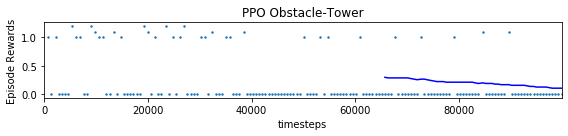

In [0]:
from stable_baselines import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "PPO Obstacle-Tower")

In [0]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    
    # Truncate x
    x = x[len(x) - len(y):]
#     print(x[-5:], y[-5:])

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.grid()
    plt.show()


[196760 197361 197962 198763 199364] [0.248 0.248 0.248 0.248 0.248]


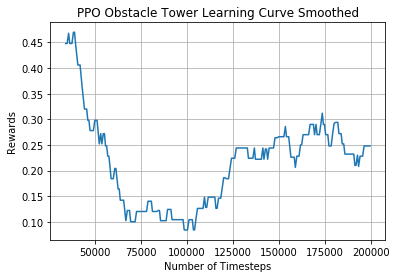

In [0]:
plot_results(log_dir, title='PPO Obstacle Tower Learning Curve')

In [0]:
env.close()